In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale

## User input

In [2]:
sample_prefix = 'E:\\Ashlee\\PacBio\\20190124_B2_nucleosomes\\B2_100X\\m190124_164714_42131_c000469382559900001500000112312160_s1_p0'

## Utility functions

In [106]:
def plot_traces(n, data, indices):
    plt.figure(figsize=(15, n*1.2))
    if n % 2 == 1:
        n = n-1
    for i in range(n):
        plt.subplot(int(n/2), 2, i+1)
        trc = data[indices[i]]
        if len(data.shape) == 2:
            plt.plot(time_axis, trc)
        else:
            for j in range(data.shape[1]):
                plt.plot(time_axis, trc[j], color=colors[j])

        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title('Trace ' + str(indices[i]))
        
#         if i%2 == 1:
#             plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
        i = i + 1
    plt.subplots_adjust(hspace=0.7)

def dtw(a1, a2):
#     s1 = np.column_stack((time_axis, a1))
#     s2 = np.column_stack((time_axis, a2))
#     return fastdtw(s1, s2)[0]
    
    return fastdtw(a1.T, a2.T)[0]

def dtw_classification(data, n_classes, n_frames, rep_trc_IDs):
    start = time()

    init_class = np.zeros((n_classes, n_frames))
    
    for i in range(n_classes):
        init_class[i] = scaled_data_cy5[rep_trc_IDs[i]]

    labels = []
    for i in range(len(data)):
        trc = data[i]
        min_dist = 1e9
        curr_label = 0
        for j in range(n_classes):
            dist = dtw(trc, init_class[j])
            if dist < min_dist:
                min_dist = dist
                curr_label = j
        labels.append(curr_label)

    print("Time passed: " + str(time() - start))
    return labels

def class_extractor(labels, n_classes):
    cls_members = {}
    for i in range(len(labels)):
        cls = labels[i]
        if cls in cls_members.keys():
            cls_members[cls].append(i)
        else:
            cls_members[cls] = [i]
    return cls_members

## Load data

In [4]:
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

In [90]:
time_axis = np.arange(n_frames)*frame_rate*3

In [5]:
# Skip decode
traces = raw_traces

## Classification using DTW as distance metric

In [6]:
n_frames_raw = n_frames
n_frames = np.int(np.floor(n_frames_raw/3))
scaled_data_cy5 = np.zeros((n_traces, n_frames))

# smoothen the data
for j in range(n_traces):
    trc = traces[j, 2, :] # cy5
    for i in range(n_frames):
        raw_i = i*3 + 1
        scaled_data_cy5[j, i] = (np.float64(trc[raw_i-1]) + np.float64(trc[raw_i]) + np.float64(trc[raw_i+1]))/3

for i in range(n_traces):
    cy5_trc = scaled_data_cy5[i]
    cy5_min = cy5_trc.min()
    cy5_max = cy5_trc.max()
    if cy5_min == cy5_max:
        scaled_data_cy5[i] = np.ones(cy5_trc.shape)
    else:
        scaled_data_cy5[i] = (cy5_trc - cy5_min) / (cy5_max - cy5_min)

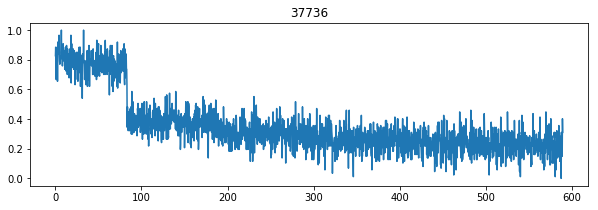

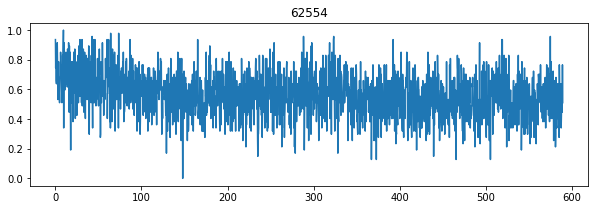

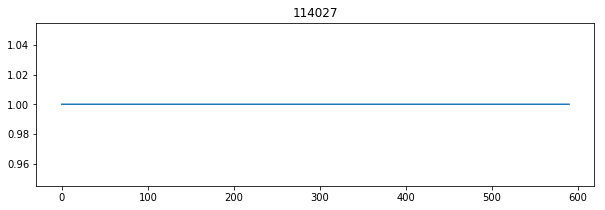

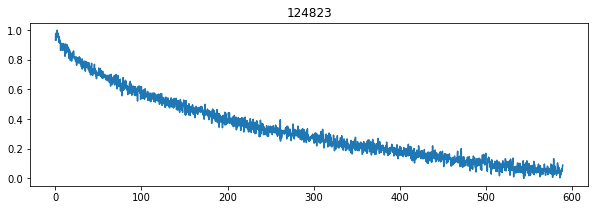

In [109]:
for i in [37736, 62554, 114027, 124823]:
    r = np.random.randint(0, n_traces)
    trc = scaled_data_cy5[i]
    plt.figure(figsize=(10, 3))
    plt.plot(time_axis, trc)
    plt.title(i)

In [ ]:
# avg_intens = np.mean(scaled_data_cy5, axis=1)
# centered_traces = np.zeros(scaled_data_cy5.shape)
# for i in range(n_traces):
#     centered_traces[i] = scaled_data_cy5[i] - avg_intens[i]

# # Compute cross-correlation
# corr_list = np.zeros(n_traces)
# for i in range(n_traces):
#     cy3 = centered_traces[i][0]
#     cy5 = centered_traces[i][2]
#     corr_list[i] = np.correlate(cy3, cy5)

# sorting_index = np.argsort(corr_list)

In [ ]:
# neg_set = sorting_index[:1000]
# rand_set = np.random.randint(0, n_traces, size=(1000,))

# test_data2 = np.zeros((2000, n_frames))

# for i in range(1000):
#     m = neg_set[i]
#     n = rand_set[i]
#     test_data2[2*i] = scaled_data_cy5[m]
#     test_data2[2*i+1] = scaled_data_cy5[n]

In [97]:
labels_all = dtw_classification(scaled_data_cy5, 4, n_frames, [37736, 62554, 114027, 124823])

Time passed: 103414.16811704636


(array([45526.,     0.,     0., 51680.,     0.,     0.,   503.,     0.,
            0., 65773.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

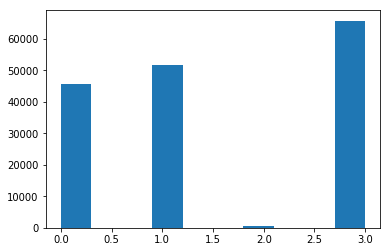

In [103]:
plt.hist(labels_all)

In [114]:
classes = class_extractor(labels_all, 4)

In [ ]:
class0_traces  